In [140]:
from spx_analysis import simulate_market 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [171]:
spx = pd.read_csv('^GSPC.csv', index_col=0)

spx.index = pd.to_datetime(spx.index)
spx['daily_chg'] = np.log(spx['Adj Close']) - np.log(spx['Adj Close'].shift(1))

#sims = 50
#markets = np.empty((60*252, sims))
#for j in range(sims):
#    markets[:, j] = simulate_market(60, spx['daily_chg'][-20*252:]*100)['Price']

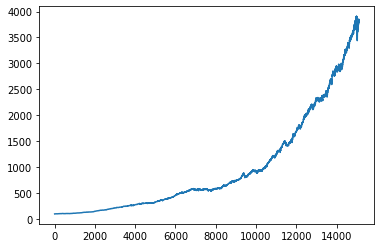

In [169]:
plt.plot(markets.mean(axis=1))

In [196]:
from datetime import datetime as dt, timedelta
years = 60

date_today = dt.today()
days = pd.date_range(date_today, periods = years*252, freq='B')

# Random market
market = simulate_market(years, spx['daily_chg'][-20*252:]*100)
market.set_index(days, inplace=True)

# Annualizing returns
market = market.asfreq('Y', method='ffill')

# 
